In [8]:
# Libraries
import os
from importlib import reload
import keras
import tensorflow as tf

# Scripts
from acml import data, runners, utils

In [9]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [10]:
reload(data)

<module 'acml.data' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\data.py'>

In [11]:
reload(runners)

<module 'acml.runners' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\runners.py'>

## `main`

In [12]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓


### Load data

In [13]:
# FULL DATASET:
# --- Takes _ minutes to run with data in csv --- #
# --- Takes 6 minutes to run with data in npz --- #

fold_dfs = data.get_fold_dfs_with_data(
    fold_definition_csv='data/deepship_5k_seg_3s.csv',
    new_path_to_root='data/csv_deepship_original_npz',
    npz=True,
    label_encodings={0:'Tanker', 1:'Cargo', 2:'Tug', 3:'Passengership'},
    n_folds=None
)
print('Successfully loaded folds with spectrograms.\n')

Successfully loaded folds with spectrograms.



In [14]:
fold_dfs[0]['spectrogram'][0].shape

(6, 187)

In [15]:
k_folds = data.get_tf_datasets_for_all_folds(
    fold_dfs, 
    conv_channel=True,
    validation_split=0.2,
    verbose=True
)


Processing fold: 1

Data dimensions:
X_train shape: (48968, 6, 187, 1)
X_test shape: (4534, 6, 187, 1)
y_train shape: (48968, 4)
y_test shape: (4534, 4)

Processing fold: 2

Data dimensions:
X_train shape: (48004, 6, 187, 1)
X_test shape: (5498, 6, 187, 1)
y_train shape: (48004, 4)
y_test shape: (5498, 4)

Processing fold: 3

Data dimensions:
X_train shape: (48161, 6, 187, 1)
X_test shape: (5341, 6, 187, 1)
y_train shape: (48161, 4)
y_test shape: (5341, 4)

Processing fold: 4

Data dimensions:
X_train shape: (45776, 6, 187, 1)
X_test shape: (7726, 6, 187, 1)
y_train shape: (45776, 4)
y_test shape: (7726, 4)

Processing fold: 5

Data dimensions:
X_train shape: (47693, 6, 187, 1)
X_test shape: (5809, 6, 187, 1)
y_train shape: (47693, 4)
y_test shape: (5809, 4)

Processing fold: 6

Data dimensions:
X_train shape: (47669, 6, 187, 1)
X_test shape: (5833, 6, 187, 1)
y_train shape: (47669, 4)
y_test shape: (5833, 4)

Processing fold: 7

Data dimensions:
X_train shape: (48435, 6, 187, 1)
X_te

### Initialise model

In [16]:
from models import cnn_lstm

cnn_lstm_model = cnn_lstm.get_cnn_lstm(
    input_shape=tuple(k_folds[0][0].element_spec[0].shape)[1:],
    input_name='spectrogram',
    num_classes=4,
    verbose=True
)

cnn_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

Model: "cnn_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectrogram (InputLayer)    [(None, 6, 187, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 6, 187, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 6, 187, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 6, 187, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 94, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 94, 64)         369

### Configure model

In [17]:
# These are kwargs for Model.fit() and Model.evaluate() excluding x and y.
fit_kwargs = {
    'epochs': 20,
    'verbose': 1,
    'callbacks': [cnn_lstm.callback_early_stop()]
}

eval_kwargs = {
    'verbose': 1
}

### Run k-fold cross val

In [18]:
model, histories, evals = runners.k_fold_cross_validation_tf_dataset(
    k_folds=k_folds,
    model=cnn_lstm_model,
    fit_kwargs=fit_kwargs,
    eval_kwargs=eval_kwargs,
    use_cpu=False
)

FOLD 1
Epoch 1/20
1225/1225 [==============================] - 28s 19ms/step - loss: 0.7280 - accuracy: 0.8735 - val_loss: 5.4854 - val_accuracy: 0.2038
Epoch 2/20
1225/1225 [==============================] - 22s 18ms/step - loss: 0.9295 - accuracy: 0.7357 - val_loss: 2.3362 - val_accuracy: 0.1464
Epoch 3/20
1225/1225 [==============================] - 22s 18ms/step - loss: 1.0760 - accuracy: 0.6603 - val_loss: 3.1222 - val_accuracy: 0.2037
Epoch 4/20
1225/1225 [==============================] - 22s 18ms/step - loss: 1.1714 - accuracy: 0.6215 - val_loss: 2.2530 - val_accuracy: 0.1964
Epoch 5/20
1225/1225 [==============================] - 22s 18ms/step - loss: 1.2268 - accuracy: 0.5282 - val_loss: 2.6045 - val_accuracy: 0.2048
Epoch 6/20
1225/1225 [==============================] - 22s 18ms/step - loss: 1.2331 - accuracy: 0.5279 - val_loss: 3.8499 - val_accuracy: 0.2038
Epoch 7/20
1225/1225 [==============================] - 22s 18ms/step - loss: 1.2562 - accuracy: 0.5005 - val_loss: 1

### Calculate metrics

In [19]:
reload(utils)

<module 'acml.utils' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\utils.py'>

In [20]:
loss, acc = utils.calculate_metrics(evals)
print(f"Average loss: {loss}")
print(f"Average accuracy: {acc}")

Average loss: 4.138442862033844
Average accuracy: 0.35924610793590545


C:\Users\sonar\AppData\Local\Temp\ipykernel_19308\201228151.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


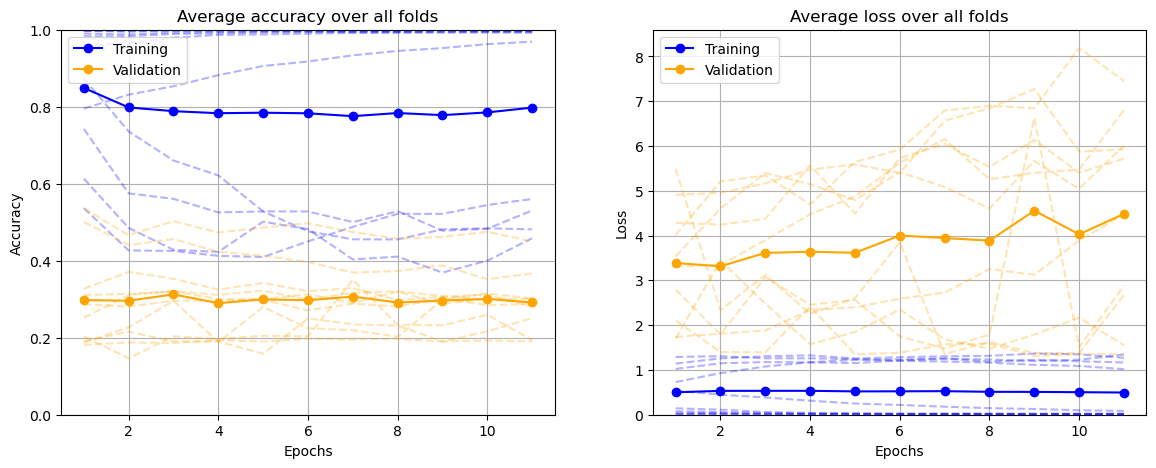

In [21]:
fig = utils.get_acc_loss_curves(histories, overlay=True)
fig.show()

In [22]:
model.save('models\cnn_lstm_tf_datasets.keras')